In [1]:
import scvelo as scv
import dynamo as dyn
import numpy as np
from anndata import AnnData
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix,issparse
import pandas as pd
import seaborn as sns

import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

import sys
sys.path.append('..')

method = ''
from g2g_model_Fisher import *
from utils import *
from RKHS import *
#import palantir

import scipy.sparse as sp
import anndata as ad
from scipy.sparse import coo_matrix

In [2]:
import matplotlib
print(matplotlib.__version__)

3.7.3


In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# print(torch.cuda.current_device())

1.11.0
None
False
0


In [4]:
result_path = 'result/noise/'
data_path='data/'
# choose the dataset
data_name = 'DG_ori_bin'
# data_name = 'A549_emt_bin'
# data_name = 'EG_bin'
# data_name = 'DG_DUBstepR'
# data_name = 'EG_branch'

adata0 = scv.read(data_path+'DG_ori_bin.h5ad', cache=True)

# set the parameters
[k_nei, K, L] = [15, 3, 10]
# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'

cmap = plt.colormaps['Spectral_r']

In [5]:
adata0

AnnData object with n_obs × n_vars = 3184 × 678
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [6]:
np.sum((adata0.X.A>0).astype(np.float32))

373680.0

In [7]:
def add_biologically_plausible_dropout(adata, dropout_factor=0.1):
    """
    模拟基因表达依赖的dropout
    :param dropout_factor: 控制整体dropout率 (0.01~0.1)
    """
    X = adata.X
    Xs= adata.layers['spliced']
    Xu= adata.layers['unspliced']
    if sp.issparse(X):
        X = X.tocsr()
        Xs = Xs.tocsr()
        Xu = Xu.tocsr()
        
    
    # 基因平均表达水平 (log转换)
    gene_means = np.log1p(np.array(X.mean(axis=0)).flatten())
    
    # 计算每个基因的dropout概率 (低表达基因概率高)
    base_dropout_rate = 1 / (1 + np.exp(10*(gene_means - gene_means.mean())))
    print(np.max(base_dropout_rate))
    adjusted_dropout_rate = base_dropout_rate * dropout_factor
    
    # 按基因应用dropout
    for gene_idx in range(adata.n_vars):
        cell_mask = np.random.rand(adata.n_obs) < adjusted_dropout_rate[gene_idx]
        if sp.issparse(X):
            X[cell_mask, gene_idx] = 0
            Xs[cell_mask, gene_idx] = 0
            Xu[cell_mask, gene_idx] = 0
        else:
            X[cell_mask, gene_idx] = 0
            Xs[cell_mask, gene_idx] = 0
            Xu[cell_mask, gene_idx] = 0
    
    adata.X = X
    adata.layers['spliced']=Xs
    adata.layers['unspliced']=Xu
    adata.X.eliminate_zeros()
    adata.layers['spliced'].eliminate_zeros()
    adata.layers['unspliced'].eliminate_zeros()



In [29]:
dropout_factor=0.2## 要先设置为0.01作为baseline运行之后所有的单元格，pseudotime以这个的结果为准,然后在这里改成需要的概率运行之后的所有单元格
adata0 = scv.read(data_path+'DG_ori_bin.h5ad', cache=True)
add_biologically_plausible_dropout(adata0,dropout_factor=dropout_factor)
np.sum((adata0.X.A>0).astype(np.float32))

0.92547935


347821.0

In [30]:
np.sum((adata0.layers['spliced'].A>0).astype(np.float32))

347821.0

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/3184 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 6 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


C:\Users\76745\anaconda3\envs\pytorch\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


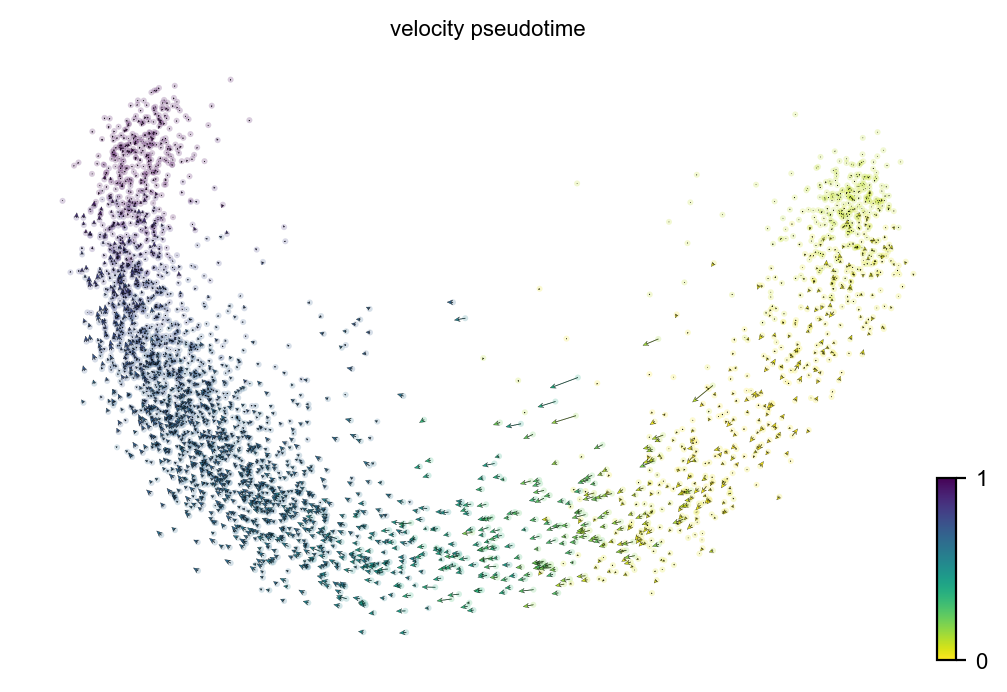

In [31]:
#-------data preprocessing
adata = adata0.copy()

scv.pp.filter_and_normalize(adata)
# scv.pp.log1p(adata)
scv.pp.neighbors(adata, n_neighbors=k_nei, metric=metric)
scv.pp.pca(adata,n_comps=50)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)
scv.tl.umap(adata)
scv.tl.velocity(adata,mode='stochastic',perc=[5, 95])

scv.tl.velocity_graph(adata,xkey='Ms')
scv.tl.velocity_pseudotime(adata)
scv.pl.velocity_embedding(adata, basis='pca',color='velocity_pseudotime')

In [32]:
# adata.uns['zero_modifications']=adata0.uns['zero_modifications']

In [33]:
gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
if dropout_factor == 0.01:
    cell_vpt = adata.obs['velocity_pseudotime'].values  ##cell_vpt使用drop_out = 0.01的velocity_pseudotime
else:
    print('change:',SUMXMS - np.sum(adata.layers['Ms']))
SUMXMS = np.sum(adata.layers['Ms'])
Xs = adata.layers['Ms']
X = Xs

change: 22288.188


In [34]:
row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = adata.uns['neighbors']['indices'].flatten()
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

In [35]:
dc=np.mean(w_val)

cell_nei=adata.uns['neighbors']['indices']
nei_w=[]
rho_arr=[]
for ni in adata.uns['neighbors']['indices']:
    dij=np.array([np.linalg.norm(X_pca[int(ni[0]),:]-X_pca[int(i),:]) for i in ni[1:]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
#     rho=np.exp(np.sum(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
#     print(dij)
#     print(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)
nei_w=np.hstack((np.ones((nei_w.shape[0],1)),nei_w))/2

# plt.scatter(X_pca[:,0],X_pca[:,1],s=5,c=rho_arr,cmap=plt.cm.jet)
# plt.colorbar()
# plt.show()

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_s

In [36]:
# define the parameters of training
epochs = 200
nsamples = 5
learning_rate = 1e-3
seed = 2025
# n_workers = 4

if seed is not None:
    reset_seeds(seed)

# prepare the data for training
A = A_mat
z = cell_vpt

n = A.shape[0]
train_nodes, val_nodes = train_test_split(n, train_ratio=1.0)
A_train = A[train_nodes, :][:, train_nodes]
X_train = X[train_nodes]
z_train = z[train_nodes]
A_val = A[val_nodes, :][:, val_nodes]
X_val = X[val_nodes]
z_val = z[val_nodes]

train_data = AttributedGraph(A_train, X_train, z_train, K)
val_data = AttributedGraph(A_val, X_val, z_val, K)

In [37]:
# initialize the encoder
encoder = Encoder(X.shape[1], L)
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = epochs #// n_workers
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
#     num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

In [38]:
# training
for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()

    loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
    if batch_idx% 10 == 0:
        print(batch_idx,loss)
    loss.backward()
    optimizer.step()

0 tensor(2.0935e+10, grad_fn=<DivBackward0>)
10 tensor(1.8620e+09, grad_fn=<DivBackward0>)
20 tensor(1.6876e+09, grad_fn=<DivBackward0>)
30 tensor(1.6092e+09, grad_fn=<DivBackward0>)
40 tensor(1.5667e+09, grad_fn=<DivBackward0>)
50 tensor(1.5563e+09, grad_fn=<DivBackward0>)
60 tensor(1.5422e+09, grad_fn=<DivBackward0>)
70 tensor(1.5273e+09, grad_fn=<DivBackward0>)
80 tensor(1.5312e+09, grad_fn=<DivBackward0>)
90 tensor(1.5433e+09, grad_fn=<DivBackward0>)
100 tensor(1.5512e+09, grad_fn=<DivBackward0>)
110 tensor(1.5182e+09, grad_fn=<DivBackward0>)
120 tensor(1.5110e+09, grad_fn=<DivBackward0>)
130 tensor(1.5261e+09, grad_fn=<DivBackward0>)
140 tensor(1.5035e+09, grad_fn=<DivBackward0>)
150 tensor(1.5121e+09, grad_fn=<DivBackward0>)
160 tensor(1.5107e+09, grad_fn=<DivBackward0>)
170 tensor(1.5179e+09, grad_fn=<DivBackward0>)
180 tensor(1.4862e+09, grad_fn=<DivBackward0>)
190 tensor(1.5066e+09, grad_fn=<DivBackward0>)


In [39]:
result_path = 'result/noise/'
result_path = result_path+f'{dropout_factor}/'
import os
folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)
result_path

'result/noise/0.2/'

In [40]:
torch.save(encoder,result_path+'encoder.pt')

In [41]:
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

In [42]:
# calculate curvature
cRc_arr_eu=[]

for inds in np.split(A.indices, A.indptr)[1:-1]:
    self_ind=inds[0]
    cRc_eu=0
    for nei_k in range(1,len(inds)):
        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        cRc_eu+=1-dWa/dEu
    cRc_arr_eu.append(cRc_eu/len(inds))
crc_eu = np.array(cRc_arr_eu)
crc_smooth = smooth_func(crc_eu)

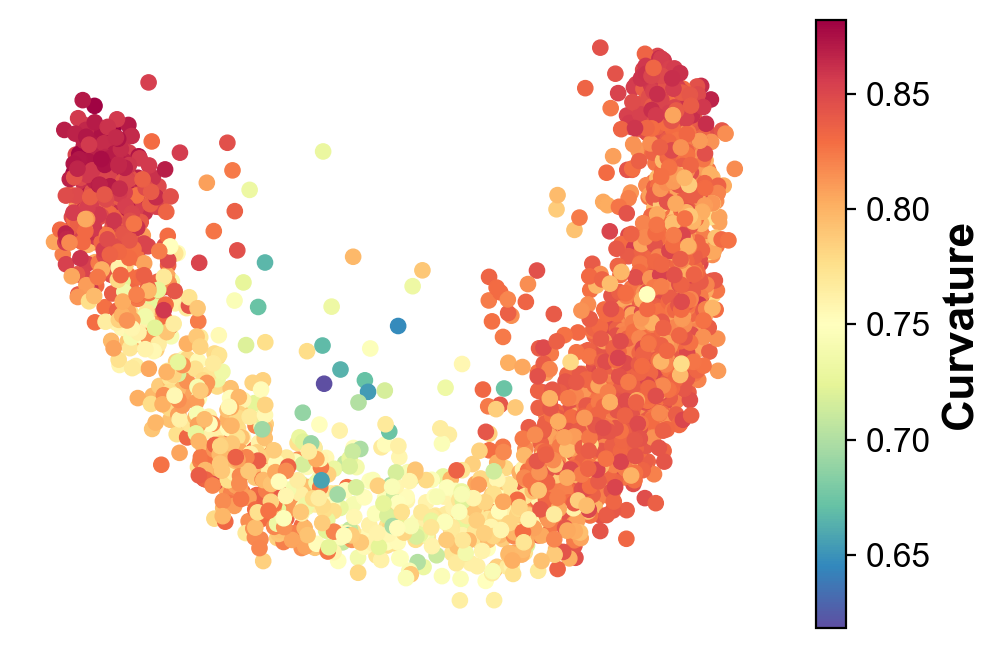

In [43]:
plt.scatter(-X_pca[:,0],X_pca[:,1], c=crc_smooth, s=30, cmap=cmap)
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC2',fontsize=14)

clb=plt.colorbar()
clb.ax.set_ylabel('Curvature',fontsize=16,weight='bold')
clb.ax.tick_params(axis='y', labelsize=12)
plt.axis('off')
plt.savefig(result_path+'DG_curvature.png')
plt.show()

In [44]:
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()
latent_z = np.hstack((mu_learned,sigma_learned))

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

In [45]:
velo0 = np.array(adata.layers['velocity'])
velo_g = np.zeros(velo0.shape)
velo_g[:,adata.var['velocity_genes']] = velo0[:,adata.var['velocity_genes']]
velo_pca = adata.obsm['velocity_pca']

In [46]:
#------use a simple neural network to study dmu/dt and dsigma/dt
pca_dim = 50
from torch.optim import SGD
reset_seeds(0)

model = nn.Sequential(
    nn.Linear(pca_dim, 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.01, weight_decay=0.001)#, momentum=0.2

x_in=torch.tensor(X_pca.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(200):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
#     if epoch% 10 == 9:
#         print(epoch,loss)
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

pZ_pX = np.zeros([X.shape[0], L*2, X_pca.shape[1]])

# Compute the gradients
for i in range(X.shape[0]):
    x0=torch.tensor(X_pca[i,:],requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pX[i,j,:] = x0.grad.detach()

Z_velo = np.array([pZ_pX[i]@velo_pca[i] for i in range(X.shape[0])])

zv2 = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    for j in range(L):
        # zv2[i] += Fisher_g[i,2*j,2*j]*Z_velo[i,2*j]**2 + Fisher_g[i,2*j+1,2*j+1]*Z_velo[i,2*j+1]**2
        zv2[i] += Fisher_g[i,j,j]*Z_velo[i,j]**2 + Fisher_g[i,L+j,L+j]*Z_velo[i,L+j]**2
zv1 = np.sqrt(zv2)
zv1_smooth = smooth_func(zv1)

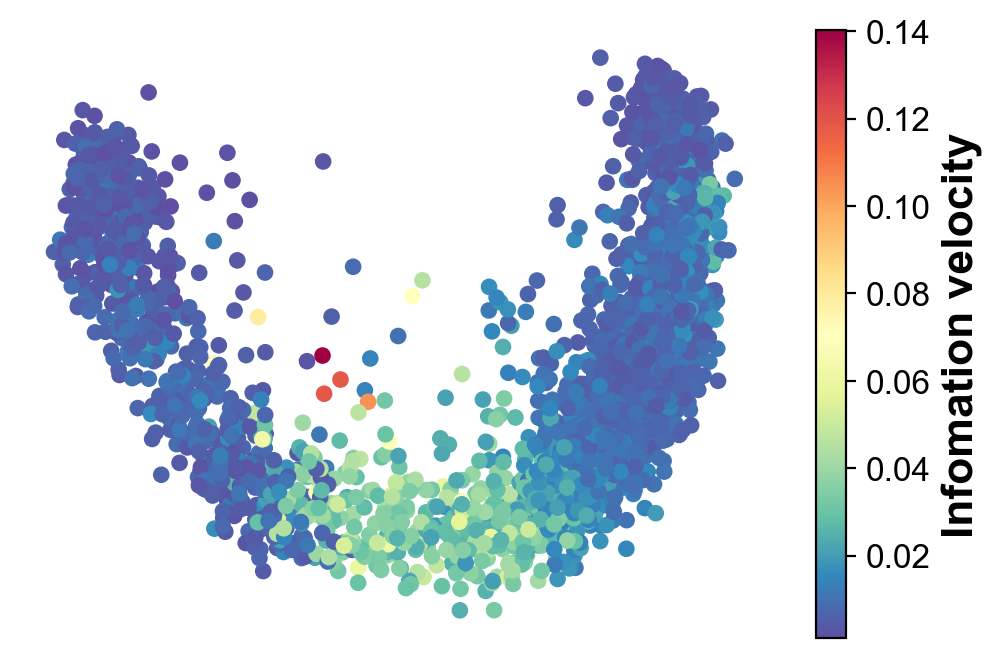

In [47]:
plt.scatter(-X_pca[:,0],X_pca[:,1],s=30,c=zv1_smooth,cmap=cmap)
plt.axis('off')


clb=plt.colorbar()
clb.ax.set_ylabel('Infomation velocity',fontsize=16,weight='bold')
clb.ax.tick_params(axis='y', labelsize=12)

plt.savefig(result_path+'DG_iv.png')
plt.show()

In [48]:
import seaborn as sns

palette1 = sns.color_palette('bright')
palette2 = sns.color_palette('pastel')
c1 = tuple((np.array(palette1[0])+np.array(palette1[-1]))/2)
c2 = tuple((np.array(palette2[0])+np.array(palette2[-1]))/2)

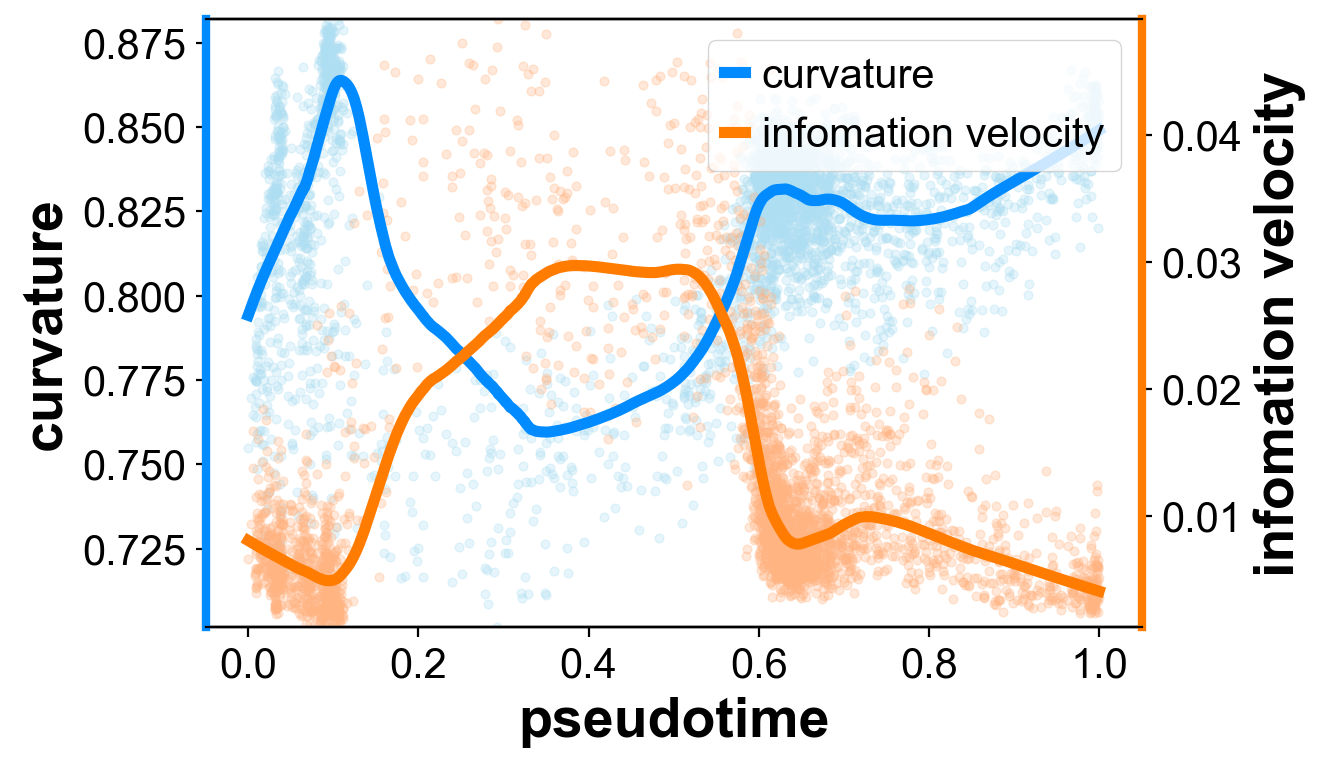

In [49]:
alpha = 0.3
frac = 0.3

plt.figure(figsize=(6,4))
mask1,x_ls1,y_ls1 = kde_lowess(cell_vpt,crc_smooth)
plt.scatter(cell_vpt[mask1], crc_smooth[mask1],s=10,c=c2,alpha=alpha)
plt.xlabel('pseudotime',fontsize=20,weight='bold')
plt.ylabel('curvature',fontsize=20,weight='bold')
plt.xticks(fontsize=15)
#plt.gca().set_xticklabels(['']*6)
plt.yticks(fontsize=15)
plt.ylim(min(crc_smooth[mask1]),max(crc_smooth[mask1]))

plt.twinx()
mask2,x_ls2,y_ls2 = kde_lowess(cell_vpt,zv1_smooth)
plt.scatter(cell_vpt[mask2], zv1_smooth[mask2],s=10,c=palette2[1],alpha=alpha)
plt.yticks([])
plt.ylim(min(zv1_smooth[mask2]),max(zv1_smooth[mask2]))

plt.twinx()
ln1 = plt.plot(x_ls1, y_ls1, linewidth=4,color=c1,label='curvature')
plt.yticks([])
plt.ylim(min(crc_smooth[mask1]),max(crc_smooth[mask1]))

plt.twinx()
ln2 = plt.plot(x_ls2, y_ls2, linewidth=4,color=palette1[1],label='infomation velocity')
plt.yticks(fontsize=15)
plt.ylabel('infomation velocity',fontsize=20,weight='bold')
plt.ylim(min(zv1_smooth[mask2]),max(zv1_smooth[mask2]))

ax = plt.gca()
ax.spines['left'].set_color(c1)
ax.spines['right'].set_color(palette1[1])
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
plt.legend(handles=ln1+ln2,fontsize=15)

plt.savefig(result_path+'DG_dropout.png',dpi=600,bbox_inches='tight')
plt.show()